In [1]:
# Policzyć trafność etykietowania przez model względem oryginalnych etykiet po każdym batchu <--
# Accuracy liczyć tylko dla aktualnego batcha, nie całego training setu (najpierw test, potem train lub na odwrót) <--
# Sprawdzić czy w paperach było to opisane
# Sprawdzić w paperach co robili z nową klasą bo nie da się jej wykryć
# Wersja 3 klasowa w 3D danych
# Procent błędnych klasyfikacji dla każdej klasy <--
# Notatki z kartki

In [2]:
# Porównać czas i wyniki z zachowaniem wszystkiego w training secie i z ograniczonym training setem <--
# Zwiększyć bufor training set do 1000 <--
# Sprawdzić czy wszystko ok jeśli accuracy jest 1.0 i co się dzieje kiedy pojawia się nowa klasa <--
# Sprawdzać ile skupisk jest w każdej chwili <--
# Notatki w telefonie <--
# Wykresy wygenerować do accuracy <--
# Naprawić bug z pustym skupieniem <--

In [3]:
# Problem with algorithm: it obtains no new labels and uses his own labeling as ground truth 
# so we get false 1.0 accuracy even if it should be lower
# Modify so that number of clusters can also grow not only get smaller
# Budget parameter - how to choose which labels to use if all examples have available labels
# Weigh examples according to the way they obtained their labels

In [4]:
# What to do if baseline results are worse than in the paper? (if a bit worse it's fine, we'll treat ours as baseline)
# What to do if approach with n_clusters adjustment in paper is bad? (introduce a modification later)
# What to do with constantly growing training set?
# How to remove old examples that deteriorate performance?
# Adjust 2D dataset for more gradual drift

In [5]:
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import cluster
from river import stream
from river.utils import dict2numpy
from collections import Counter
from tqdm import tqdm
import time

# FastCOMPOSE pipeline

In [6]:
# TODO Bug in cluster and label when assigning a label to new example and assigned cluster is empty <--
# TODO Modify n_clusters adjustment in KMeans <--
# - which examples treat as labeled and which as not
# - retrain on training set when adjusting number of labels
# TODO Maybe add information to dataset if an example was obtained labeled or was labeled by the algorithm
# TODO Add budget parameter to denote how many examples are actually labelled

class FastCOMPOSE:
    def __init__(self, data, labels, training_set_size):
        self.training_set_size = training_set_size
        self.training_set_data = deque()
        self.training_set_labels = deque()
        
        self.n_clusters = 5
        self.clustering_algorithm = cluster.KMeans(n_clusters=self.n_clusters)
        
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            self._train_clustering(x)
            # Add labeled data to the training set
            self._add_data_to_training_set([(x, y)])
            
    def _calculate_accuracy(self, data, labels):
        # Calculate accuracy on current batch
        accuracy = 0
        accuracy_per_class = {label: [] for label in np.unique(labels)}
        
        num_clusters = len(self.clustering_algorithm.centers)
        clusters = {idx: {"data": [], "labels": []} for idx in range(num_clusters)}
        
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self._predict_clustering(x)
            clusters[cluster]["data"].append(x)
            clusters[cluster]["labels"].append(y)
            
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            cluster = self._predict_clustering(x)
            # Predict label using majority voting for the assigned cluster 
            y_pred = max(set(clusters[cluster]["labels"]), key=clusters[cluster]["labels"].count)
            accuracy += (y == y_pred)
            accuracy_per_class[y].append(y == y_pred)
            
        accuracy /= len(data)
        accuracy_per_class = {label: np.mean(scores) for label, scores in accuracy_per_class.items()}
        
        return accuracy, accuracy_per_class
            
    def _add_data_to_training_set(self, labeled_data):
        for x, y in labeled_data:
            if self.training_set_size and len(self.training_set_data) == self.training_set_size:
                self.training_set_data.popleft()
                self.training_set_labels.popleft()
            self.training_set_data.append(dict2numpy(x))
            self.training_set_labels.append(y)
            
    def _train_clustering(self, x):
        self.clustering_algorithm = self.clustering_algorithm.learn_one(x)
            
    def _predict_clustering(self, x):
        cluster = self.clustering_algorithm.predict_one(x)
        return cluster
    
    def _retrain_if_empty_clusters(self, clusters):
        self.n_clusters -= 1
        self.clustering_algorithm = cluster.KMeans(n_clusters=self.n_clusters)
        
        print(f"Number of clusters = {self.n_clusters}")
            
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            self._train_clustering(x)
            
    def _train_and_cluster_training_set(self):
        num_clusters = len(self.clustering_algorithm.centers)
        clusters = {idx: {"data": [], "labels": []} for idx in range(num_clusters)}
        
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            self._train_clustering(x)
            cluster = self._predict_clustering(x)
            
            clusters[cluster]["data"].append(x)
            clusters[cluster]["labels"].append(y)
        
        return clusters
        
    def _cluster_and_label_step(self, data, labels):
        clusters = self._train_and_cluster_training_set()
            
        # If some clusters are empty retrain model with smaller number of clusters
        while np.any([not cluster["labels"] for idx, cluster in clusters.items()]):
            self._retrain_if_empty_clusters(clusters)
            clusters = self._train_and_cluster_training_set()
            
        data_with_labels = []
        for i, (x, _) in enumerate(stream.iter_array(data, labels)):
            self._train_clustering(x)
            cluster = self._predict_clustering(x)
            
            # Label example using majority voting for the assigned cluster
            y = max(set(clusters[cluster]["labels"]), key=clusters[cluster]["labels"].count)
            
            clusters[cluster]["data"].append(x)
            clusters[cluster]["labels"].append(y)
            
            data_with_labels.append((x, y))
        
        # Add newly labeled data to the training set
        self._add_data_to_training_set(data_with_labels)
        
    def plot_clusters(self):
        num_clusters = len(self.clustering_algorithm.centers)
        clusters = {idx: {"data": [], "labels": []} for idx in range(num_clusters)}
        
        data_dim = self.training_set_data[0].shape[0]

        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self._predict_clustering(x)
            clusters[cluster]["data"].append(list(x.values()))
            clusters[cluster]["labels"].append(y)
            
        # Plot 3D data
        if data_dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')

        for idx, cluster in clusters.items():
            label = max(set(cluster["labels"]), key=cluster["labels"].count)
            cluster = np.vstack(cluster["data"])
            # Plot 3D data
            if data_dim == 3:
                ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=label)
            # Plot 2D data
            else:
                plt.scatter(cluster[:, 0], cluster[:, 1], label=label)
        
        plt.title("Clusters from training set with labels")
        plt.legend()
        plt.show()
                    
    def __call__(self, data, labels):
        self._cluster_and_label_step(data, labels)
        accuracy, accuracy_per_class = self._calculate_accuracy(data, labels)
        return accuracy, accuracy_per_class

In [7]:
def plot_incoming_data(data, labels):
    unique_labels = np.unique(labels)
    data_dim = data.shape[1]
    
    # Plot 3D data
    if data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    for label in unique_labels:
        # Plot 3D data
        if data_dim == 3:
            ax.scatter(data[labels == label][:, 0], data[labels == label][:, 1], data[labels == label][:, 2], label=label)
        # Plot 2D data
        else:
            plt.scatter(data[labels == label][:, 0], data[labels == label][:, 1], label=label)
    
    plt.title("Data from current batch with labels")
    plt.legend()
    plt.show()

In [8]:
def train_fast_compose(streaming_data, streaming_labels, training_set_size=1000):
    # Assume first batch (streaming_data[0], streaming_labels[0]) to be labelled to initialize algorithm
    accuracies = []
    accuracies_per_class = {label: [] for label in np.unique(streaming_labels)}
    start = time.time()

    fc = FastCOMPOSE(streaming_data[0], streaming_labels[0], training_set_size)

    for batch_idx, (data, labels) in tqdm(enumerate(zip(streaming_data[1:], streaming_labels[1:]), 1)):
        accuracy, accuracy_per_class = fc(data, labels)
        accuracies.append(accuracy)
        for label, accuracy in accuracy_per_class.items():
            accuracies_per_class[label].append(accuracy)
        # If class not present in current batch set accuracy for that class to None
        for label in accuracies_per_class.keys():
            if label not in accuracy_per_class.keys():
                accuracies_per_class[label].append(None)

    #     print(batch_idx, accuracy)

        if batch_idx % 50 == 0:
            fc.plot_clusters()
            plot_incoming_data(data, labels)

    end = time.time()
    print(f"Time elapsed: {end - start}")
    
    plt.plot(accuracies)
    plt.title("Accuracy")
    plt.show()
    
    for label, accuracy in accuracies_per_class.items():
        plt.plot(accuracy, label=f"{label}")
    plt.title("Accuracy per class")
    plt.legend()
    plt.show()
    
    return fc

# Experiments 2D

In [9]:
dataset_2d = "./2d_gaussian_data_v2.csv"

In [10]:
gaussian_data_2d = pd.read_csv(dataset_2d)
y_2d = gaussian_data_2d.pop('label').to_numpy()
X_2d = gaussian_data_2d.to_numpy()

In [11]:
X_2d.shape

(26300, 2)

In [12]:
y_2d.shape

(26300,)

In [13]:
for xi, yi in stream.iter_array(X_2d, y_2d):
    print(xi, yi)
    break

{0: 1.3084041099825865, 1: 5.271207619270895} 0


In [14]:
streaming_data_2d = np.split(X_2d, X_2d.shape[0]/100)
streaming_labels_2d = np.split(y_2d, y_2d.shape[0]/100)

In [15]:
streaming_data_2d[0].shape

(100, 2)

In [16]:
streaming_labels_2d[0].shape

(100,)

47it [00:02, 20.40it/s]

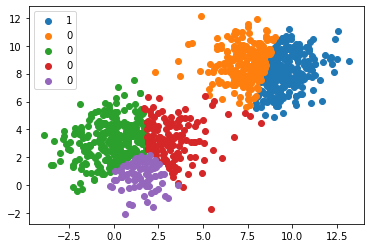

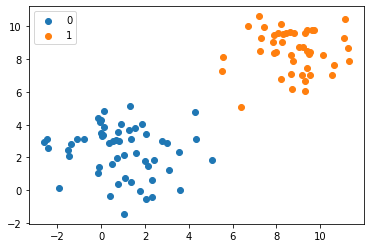

98it [00:05, 19.47it/s]

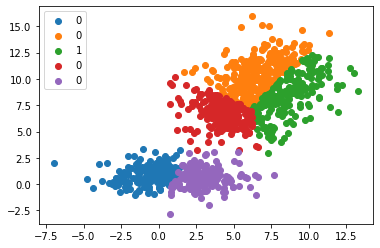

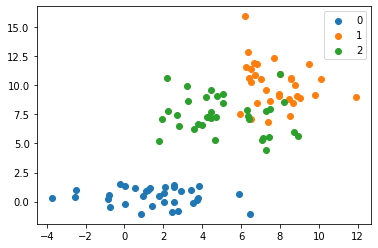

148it [00:08, 19.30it/s]

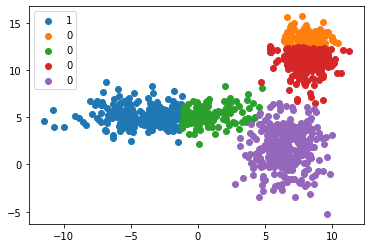

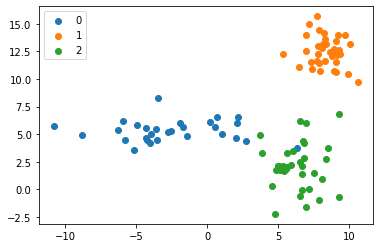

198it [00:10, 19.73it/s]

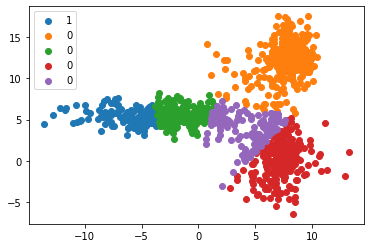

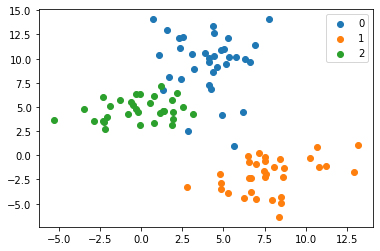

249it [00:13, 19.67it/s]

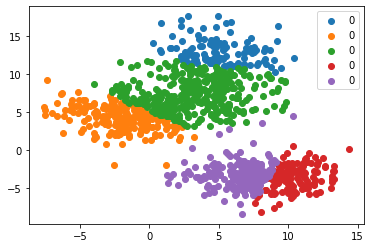

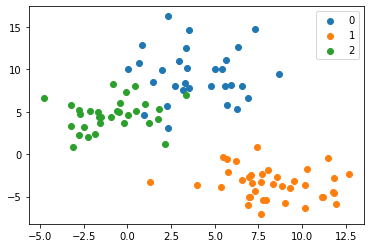

262it [00:14, 17.52it/s]


Time elapsed: 14.969917058944702


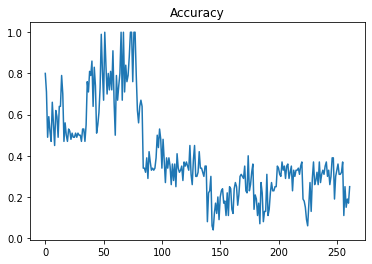

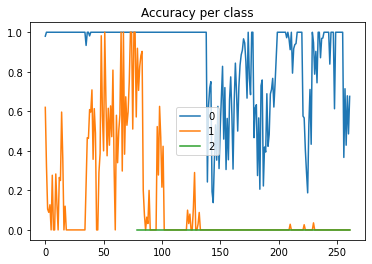

In [17]:
fc = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1000)

In [18]:
# fc = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=None)

# Experiments 3D

In [19]:
dataset_3d = "./3d_gaussian_data.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [20]:
X_3d.shape

(20200, 3)

In [21]:
y_3d.shape

(20200,)

In [22]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: 8.065993314520647, 1: 2.252267979768172, 2: 5.110438424631312} 0


In [23]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [24]:
streaming_data_3d[0].shape

(100, 3)

In [25]:
streaming_labels_3d[0].shape

(100,)

49it [00:02, 16.94it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


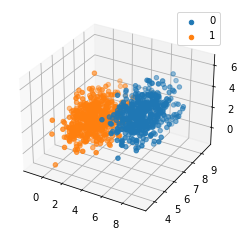

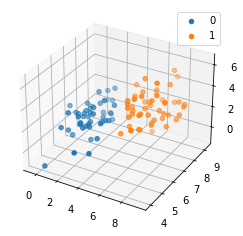

97it [00:04, 32.14it/s]

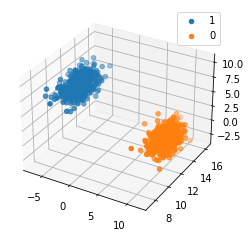

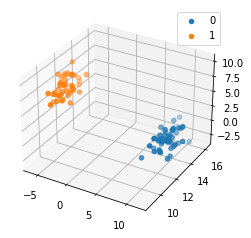

133it [00:06, 31.19it/s]

Number of clusters = 1


148it [00:06, 40.27it/s]

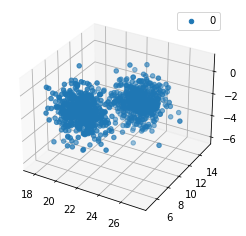

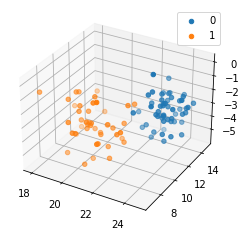

198it [00:07, 44.94it/s]

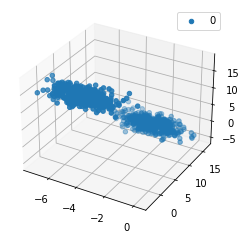

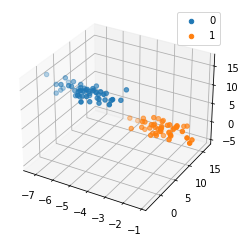

201it [00:08, 24.78it/s]

Time elapsed: 8.115230083465576


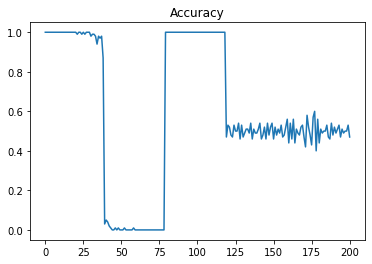

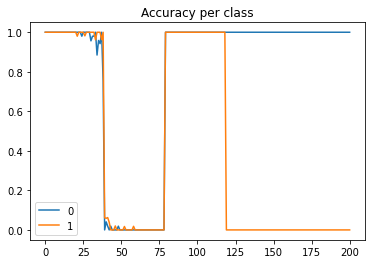

In [26]:
fc = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1000)

In [ ]:
# fc = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=None)